# Sparsity and L1 Regularization
**Suggested time to spend on exercise**: 14 minutes

Once again, we'll work on our logistic regression model. We'll use feature columns and add a significant number of features. This model will be pretty complex. Let's see if we can keep this complexity in check.

One way to reduce complexity is to use a regularization function that encourages weights to be exactly zero. For linear models such as regression, a zero weight is equivalent to not using the corresponding feature at all. In addition to avoiding overfitting, the resulting model will be more efficient.

L1 regularization is a good way to increase sparsity.

Run the cell below to load the data and create feature definitions.

In [0]:
#@test {"output": "ignore"}

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.google as tf
from IPython import display
from google3.pyglib import gfile
from sklearn import metrics

def preprocess_features(california_housing_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  various features selected and pre-processed.  The input dataframe contains
  data from the california_housing data set."""
  output_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housingMedianAge",
     "totalRooms",
     "totalBedrooms",
     "population",
     "households",
     "medianIncome"]].copy()
  output_features["roomsPerPerson"] = (
    california_housing_dataframe["totalRooms"] /
    california_housing_dataframe["population"])
  return output_features


def preprocess_targets(california_housing_dataframe):
  """This function selects and potentially transforms the output target from
  an input dataframe containing data from the california_housing data set.
  The object returned is a pandas Series."""
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # medianHouseValue is above a set threshold.
  output_targets["medianHouseValueIsHigh"] = (
    california_housing_dataframe["medianHouseValue"] > 265000).astype(float)
  return output_targets


# Load in the raw data.  Note that there's a separate test data set that we
# will leave untouched for now.
raw_training_df = pd.read_csv(
  gfile.Open("/placer/prod/home/ami/mlcc/california_housing/v1/train.csv"),
  sep=",")
# Randomize the data before selecting train / validation splits.
raw_training_df = raw_training_df.reindex(np.random.permutation(
  raw_training_df.index))

# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(raw_training_df.head(12000))
training_targets = preprocess_targets(raw_training_df.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(raw_training_df.tail(5000))
validation_targets = preprocess_targets(raw_training_df.tail(5000))

# Sanity check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

# Define the input function
def _input_fn(examples_df, targets_df):
  # Converts a pair of examples/targets DataFrames to Tensors. The Tensors are
  # reshaped into (N,1) where N is number of examples in the DataFrames.
  features = {}
  for column_name in examples_df.keys():
    features[column_name] = tf.to_float(
      tf.reshape(tf.constant(examples_df[column_name].values), [-1,1]))
  label_tensor = tf.to_float(
    tf.reshape(tf.constant(targets_df[targets_df.keys()[0]].values), [-1,1]))

  # Return a dict of feature Tensors and label Tensor.
  return features, label_tensor

# Create the feature columns.
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in xrange(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

bucketized_households = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("households"),
  boundaries=get_quantile_based_buckets(training_examples["households"], 10))
bucketized_longitude = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("longitude"),
  boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
bucketized_latitude = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("latitude"),
  boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
bucketized_housingMedianAge = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("housingMedianAge"),
  boundaries=get_quantile_based_buckets(
    training_examples["housingMedianAge"], 10))
bucketized_totalRooms = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("totalRooms"),
  boundaries=get_quantile_based_buckets(training_examples["totalRooms"], 10))
bucketized_totalBedrooms = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("totalBedrooms"),
  boundaries=get_quantile_based_buckets(training_examples["totalBedrooms"], 10))
bucketized_population = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("population"),
  boundaries=get_quantile_based_buckets(training_examples["population"], 10))
bucketized_medianIncome = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("medianIncome"),
  boundaries=get_quantile_based_buckets(training_examples["medianIncome"], 10))
bucketized_roomsPerPerson = tf.contrib.layers.bucketized_column(
  tf.contrib.layers.real_valued_column("roomsPerPerson"),
  boundaries=get_quantile_based_buckets(
    training_examples["roomsPerPerson"], 10))

long_x_lat = tf.contrib.layers.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

feature_columns = set([
  long_x_lat,
  bucketized_longitude,
  bucketized_latitude,
  bucketized_housingMedianAge,
  bucketized_totalRooms,
  bucketized_totalBedrooms,
  bucketized_population,
  bucketized_households,
  bucketized_medianIncome,
  bucketized_roomsPerPerson])

Training examples summary:


,latitude,longitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,roomsPerPerson
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,35.649706,-119.589610,28.637917,2642.878917,539.092917,1422.558667,500.215333,3.890047,1.987501
std,2.138683,2.007734,12.627632,2224.391735,429.320347,1174.975988,391.630279,1.915771,1.090303
min,32.550000,-124.350000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,0.018065
25%,33.940000,-121.812500,18.000000,1455.000000,297.000000,787.750000,281.000000,2.564300,1.530622
50%,34.270000,-118.530000,29.000000,2123.500000,431.000000,1162.000000,408.000000,3.555600,1.945770
75%,37.730000,-118.010000,37.000000,3137.000000,645.000000,1704.000000,602.000000,4.781300,2.302434
max,41.950000,-114.310000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,52.033333


Validation examples summary:


,latitude,longitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,roomsPerPerson
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,35.56647,-119.496104,28.472800,2645.549600,540.173800,1446.410600,503.637800,3.868053,1.965221
std,2.13318,1.997646,12.489214,2069.604199,402.150003,1079.909947,366.923485,1.889857,1.339654
min,32.54000,-124.300000,2.000000,15.000000,3.000000,3.000000,2.000000,0.499900,0.061605
25%,33.92000,-121.650000,18.000000,1473.000000,297.000000,795.000000,282.000000,2.568575,1.499960
50%,34.21000,-118.440000,29.000000,2142.000000,439.000000,1181.000000,412.000000,3.516750,1.932364
75%,37.68000,-117.980000,37.000000,3180.500000,658.000000,1765.000000,614.000000,4.734700,2.286216
max,41.86000,-114.560000,52.000000,26322.000000,4072.000000,12427.000000,3405.000000,15.000100,55.222222


Training targets summary:


,medianHouseValueIsHigh
count,12000.000000
mean,0.251917
std,0.434132
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Validation targets summary:


,medianHouseValueIsHigh
count,5000.000000
mean,0.244800
std,0.430012
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Calculate the model size

To calculate the model size, we simply count the number of parameters that are non-zero. We provide a helper function below to do that. The function uses intimate knowledge of the Estimators API - don't worry about understanding how it works.

In [0]:
#@test {"output": "ignore"}

def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

### Reduce the model size

Congratulations! You've been pre-selected, pre-qualified and pre-approved for testing a super-secret product: a highly accurate Logistic Regression model on the *SmartRing*, a ring that is so smart it can sense the demographics of a city block ('medianIncome', 'avgRooms', 'households', ..., etc.) and tell you whether the given city block is high cost city block or not.

Since the SmartRing is small, the engineering team has determined that it can only handle a model that has **no more than 600 parameters**. On the other hand, the product management team has determined that the model is not launchable unless the **LogLoss is less than 0.35** on the holdout test set.

Can you use your secret weapon — L1 regularization — to tune the model to satisfy both the size and accuracy constraints?

### Task 1: Find a good regularization coefficient.

**Find an L1 regularization parameter which satisfies both constraints — model size is less than 600 and log-loss is less than 0.35 on validation set.**

We pre-calculated metrics for some regularization parameters. If you don't have time, you can use the hidden hint ("Run" the block to see the hint).

The following code will help you get started. There are many ways to apply regularization to your model. Here, we chose to do it using [FtrlOptimizer](https://cs.corp.google.com/search/?q=symbol:FtrlOptimizer+f:ftrl.py$+package:piper), which is designed to give better results with L1 regularization than standard gradient descent.

Again, the model will train on the entire data set, so expect it to run slower than normal.

In [0]:
#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 0.1  # No need to change the learning rate.
# No batch size - we train on the entire training set.
STEPS = 300  # No need to change the number of steps.
REGULARIZATION_STRENGTH = 0.05 # @param

linear_classifier = tf.contrib.learn.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=tf.train.FtrlOptimizer(
    learning_rate=LEARNING_RATE,
    l1_regularization_strength=REGULARIZATION_STRENGTH),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
print "Training model..."
linear_classifier.fit(
  input_fn=lambda: _input_fn(training_examples, training_targets),
  steps=STEPS)
evaluation_metrics = linear_classifier.evaluate(
  input_fn=lambda: _input_fn(validation_examples, validation_targets),
  steps=1)
print "Loss on the validation set:", evaluation_metrics["loss"]
print "Model size:", model_size(linear_classifier)


Training model...
Loss on the validation set: 0.326093
Model size: 443


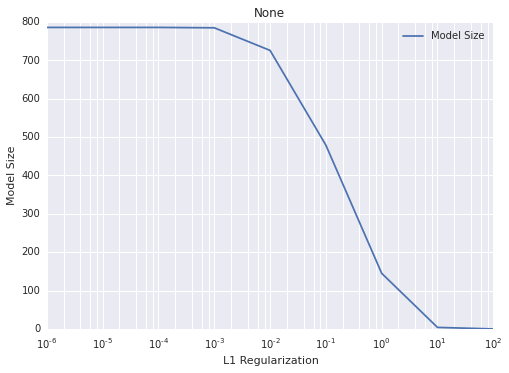

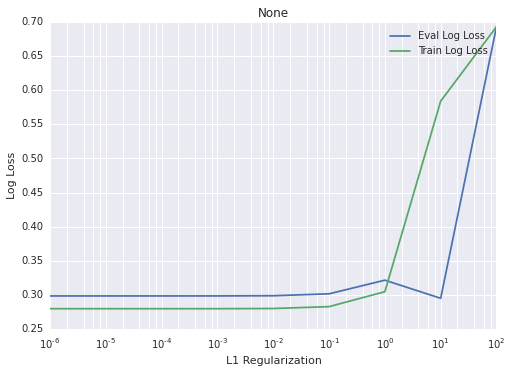

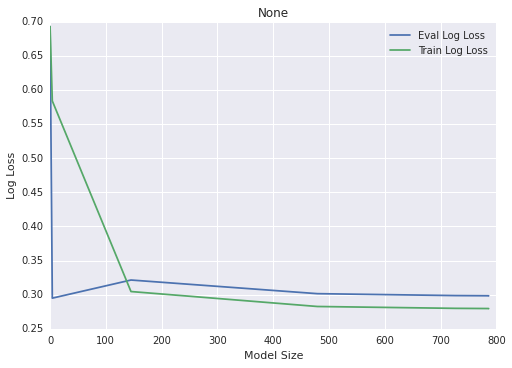

In [0]:
#@title Run Me to view a plot of pre-calculated regularization and loss graphs

#@test {"output": "ignore"}

def Plot(x, y_s, y_labels, x_axis_name, y_axis_name, title=None, xscale=None):
  plt.figure()
  for i in xrange(len(y_s)):
    plt.plot(x, y_s[i], label=y_labels[i])
  if xscale is not None:
    plt.xscale(xscale)
  plt.xlabel(x_axis_name)
  plt.ylabel(y_axis_name)
  plt.title(title)
  plt.legend()

l1_reg = [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
size = [786, 786, 786, 785, 726, 479, 145, 4, 0]
train_log_loss = [0.27968344, 0.27968374, 0.27968642, 0.27971306, 0.27998063, 0.28270981, 0.3046281, 0.58407605, 0.6931324]
eval_log_loss = [0.29840145, 0.29840168, 0.29840434, 0.29843101, 0.29870063, 0.30151531, 0.32151726,  0.29494819, 0.69314635]

Plot(l1_reg, [size], ['Model Size'], "L1 Regularization", "Model Size", xscale='log')
Plot(l1_reg, [eval_log_loss, train_log_loss], ['Eval Log Loss', 'Train Log Loss'], "L1 Regularization", "Log Loss", xscale='log')
Plot(size, [eval_log_loss, train_log_loss], ['Eval Log Loss', 'Train Log Loss'], "Model Size", "Log Loss")

In [0]:
#@title Run Me for a hint

#@test {"output": "ignore"}

print """
         Try this value:

           REGULARIZATION_STRENGTH = 0.1
      """


         Try this value:

           REGULARIZATION_STRENGTH = 0.1
      
